In [14]:
import pandas as pd

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [15]:
train.head()

Id   Open Date        City  City Group Type  P1   P2   P3   P4  P5  ...  \
0   0  07/17/1999    İstanbul  Big Cities   IL   4  5.0  4.0  4.0   2  ...   
1   1  02/14/2008      Ankara  Big Cities   FC   4  5.0  4.0  4.0   1  ...   
2   2  03/09/2013  Diyarbakır       Other   IL   2  4.0  2.0  5.0   2  ...   
3   3  02/02/2012       Tokat       Other   IL   6  4.5  6.0  6.0   4  ...   
4   4  05/09/2009   Gaziantep       Other   IL   3  4.0  3.0  4.0   2  ...   

   P29  P30  P31  P32  P33  P34  P35  P36  P37    revenue  
0  3.0    5    3    4    5    5    4    3    4  5653753.0  
1  3.0    0    0    0    0    0    0    0    0  6923131.0  
2  3.0    0    0    0    0    0    0    0    0  2055379.0  
3  7.5   25   12   10    6   18   12   12    6  2675511.0  
4  3.0    5    1    3    2    3    4    3    3  4316715.0  

[5 rows x 43 columns]

# Data Preprocessing

In [16]:
# Check for Null Values

print(train.isnull().sum())

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64


In [17]:
# Check which variables are categorical and which are numerical.

print(train.dtypes)

Id              int64
Open Date      object
City           object
City Group     object
Type           object
P1              int64
P2            float64
P3            float64
P4            float64
P5              int64
P6              int64
P7              int64
P8              int64
P9              int64
P10             int64
P11             int64
P12             int64
P13           float64
P14             int64
P15             int64
P16             int64
P17             int64
P18             int64
P19             int64
P20             int64
P21             int64
P22             int64
P23             int64
P24             int64
P25             int64
P26           float64
P27           float64
P28           float64
P29           float64
P30             int64
P31             int64
P32             int64
P33             int64
P34             int64
P35             int64
P36             int64
P37             int64
revenue       float64
dtype: object


In [18]:
# Check the data types of the values in the City column to confirm mixed types.

print(train['City'].apply(type).value_counts())
print(test['City'].apply(type).value_counts())

City
<class 'str'>    137
Name: count, dtype: int64
City
<class 'str'>    100000
Name: count, dtype: int64


1. Open Date (object)
What It Represents:

The date when the restaurant opened. This can be converted into useful features such as:

Number of days since opening (relative to a specific date like the training end date).
Year, month, or day of the week when the restaurant opened.
Preprocessing Steps:

Convert the column from object to datetime.
Extract features:
Days since opening: Helps capture the maturity of the restaurant.
Year opened, month opened: Could indicate trends or seasonality.

In [21]:
from datetime import datetime

# # Process 'Open Date': Convert to days since opening
train['Open Date'] = pd.to_datetime(train['Open Date'], format='%m/%d/%Y')
test['Open Date'] = pd.to_datetime(test['Open Date'], format='%m/%d/%Y')

# Calculate days since opening (assuming latest date in training data is 01/01/2023)
reference_date = datetime(2023, 1, 1) # Reference date (use the latest date in the training data)
train['Days_Since_Open'] = (reference_date - train['Open Date']).dt.days
test['Days_Since_Open'] = (reference_date - test['Open Date']).dt.days

# Extract year and month
train['Year_Opened'] = train['Open Date'].dt.year
train['Month_Opened'] = train['Open Date'].dt.month
test['Year_Opened'] = test['Open Date'].dt.year
test['Month_Opened'] = test['Open Date'].dt.month

# Drop the original 'Open Date' column
train.drop(['Open Date'], axis=1, inplace=True)
test.drop(['Open Date'], axis=1, inplace=True)

2. Label Encoding if you are using tree-based models (e.g., Random Forest, LightGBM, XGBoost). These models handle the splits effectively and do not rely on the ordinal nature of labels.

Combine Training and Test Cities Before Encoding
Ensure all unique city labels from both training and test datasets are included in the encoding process. This prevents the encoder from encountering unseen labels.

In [19]:
from sklearn.preprocessing import LabelEncoder

# Combine train and test City columns to account for unseen labels
combined_cities = pd.concat([train['City'], test['City']], axis=0)

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(combined_cities)

# Transform the City column in both datasets
train['City'] = label_encoder.transform(train['City'])
test['City'] = label_encoder.transform(test['City'])

In [20]:
print(train['City'].head())
print(test['City'].head())

0    60
1     4
2    14
3    52
4    21
Name: City, dtype: int64
0    42
1    31
2     4
3    30
4     1
Name: City, dtype: int64


3. City Group (object)
What It Represents:

Groups of cities:

- "Big Cities": Large urban areas.
- "Other": Smaller cities or towns.

Preprocessing Steps:

Convert the City Group into binary encoding:
- "Big Cities" -> 1
- "Other" -> 0

In [22]:
# Encode 'City Group': Binary encoding
train['City_Group'] = (train['City Group'] == 'Big Cities').astype(int)
test['City_Group'] = (test['City Group'] == 'Big Cities').astype(int)
train.drop(['City Group'], axis=1, inplace=True)
test.drop(['City Group'], axis=1, inplace=True)

4. Type (object)
What It Represents:

Type of the restaurant:

- "FC": Food Court.
- "IL": Inline.
- "DT": Drive-Thru.
- "MB": Mobile.

Preprocessing Steps:

Use One-Hot Encoding for the Type column because the values are categorical with no natural ordinal relationship.

In [23]:
# One-Hot Encoding for 'Type' (as it has few unique values)
train = pd.get_dummies(train, columns=['Type'], prefix='Type')
test = pd.get_dummies(test, columns=['Type'], prefix='Type')

In [24]:
# Align columns
test = test.reindex(columns=train.columns, fill_value=0)

In [25]:
# Separate features (X) and target variable (y)
X_train = train.drop(['Id', 'revenue'], axis=1)
y_train = train['revenue']
X_test = test.drop(['Id','revenue'], axis=1)

# Model Training

**Reasoning for the Models Used:**

- *Decision Tree Regressor (DT)*:
Decision Trees are intuitive and can handle non-linear relationships.

- *Multi-Layer Perceptron Regressor (MLP):*
MLPs are powerful for capturing non-linear relationships

- *Random Forest Regressor (RF):* ensemble models that are robust to overfitting, handle non-linear relationships well, and can capture interactions between features. Works well when there are strong feature interactions or when the dataset has moderate-to-high dimensionality, as in this case.

- *LightGBM:*  a gradient boosting algorithm optimized for speed and efficiency. It handles categorical and numerical features efficiently, making it well-suited for structured data. Particularly effective when datasets are large or have high cardinality features (e.g., City in this problem).

- *XGBoost (Gradient Boosting Framework):*
Handles large datasets efficiently.
Can capture non-linear relationships well.

- *CatBoost (Gradient Boosting for Categorical Features):*
Highly optimized for datasets with categorical features.

- *Gradient Boosting Regressor:*
Traditional gradient boosting implementation.

- *ElasticNet (Linear Model with L1 + L2 Regularization):*
Robust against multicollinearity and high-dimensional data.

***SVM and Gradient Descent are not ideal for this problem as SVMs work well for small-to-moderate datasets with high-dimensional data. However, they scale poorly with large datasets and require heavy tuning for kernel selection.Gradient Descent Regressors optimize the parameters iteratively. While this approach underpins models like MLP and linear regression, standalone implementations are rarely competitive for tabular data.***

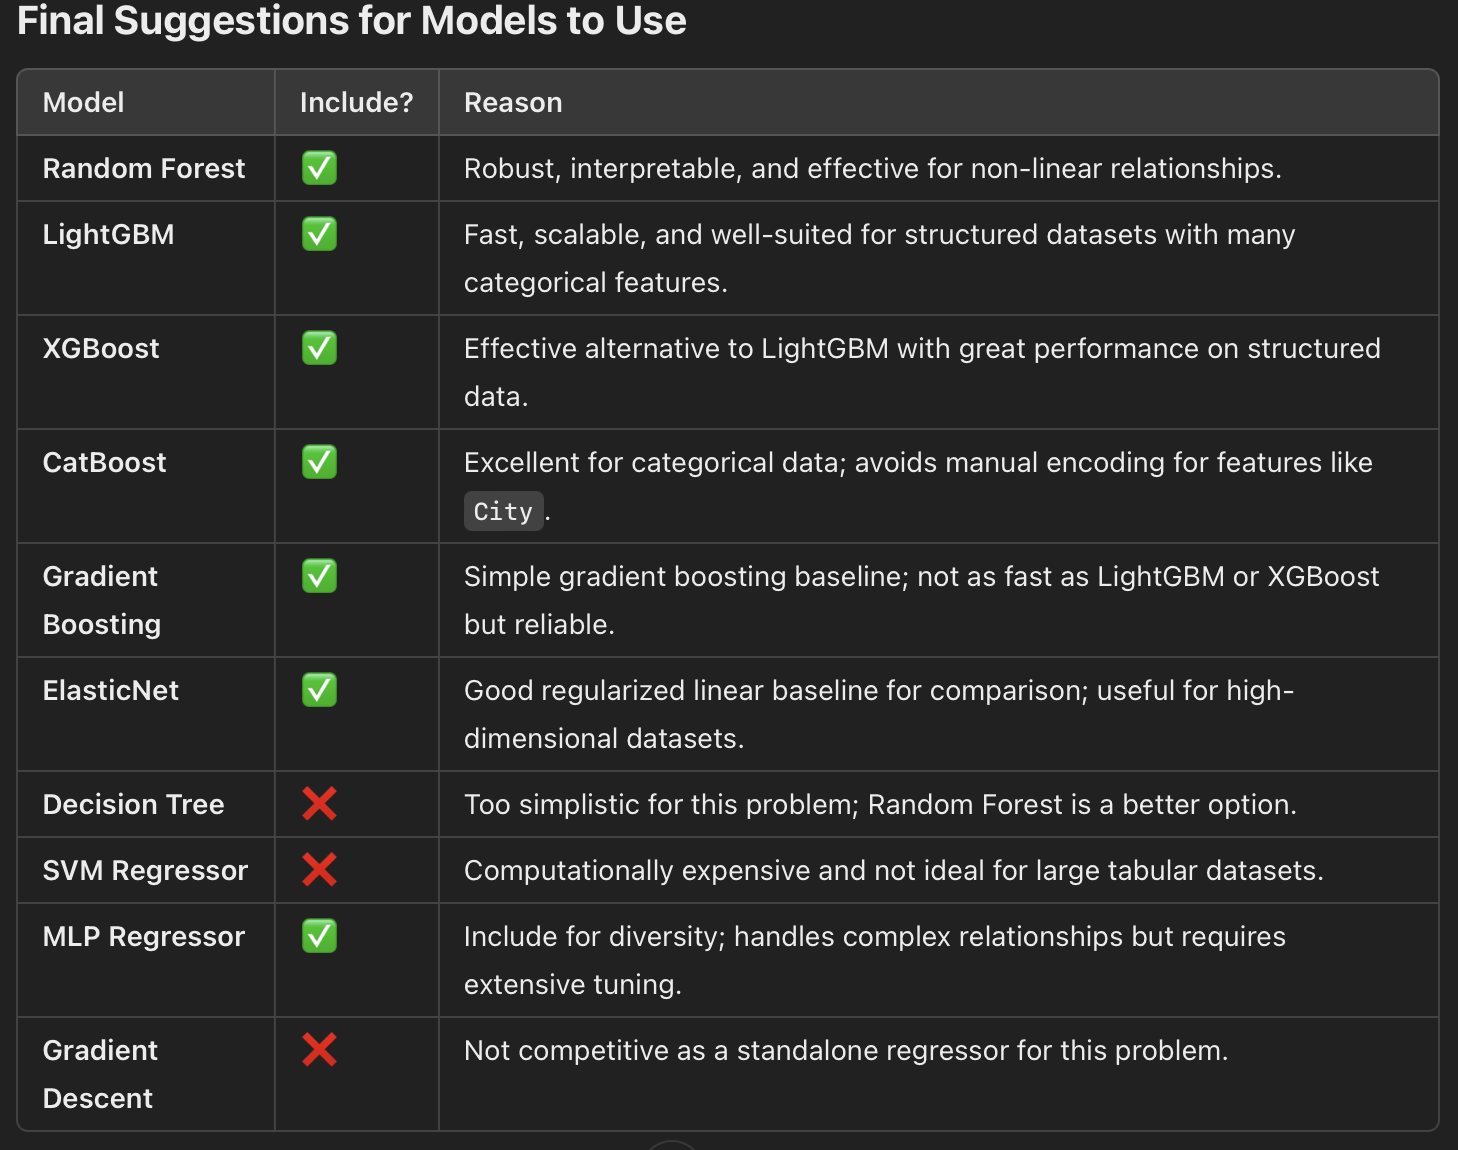

In [72]:
Image('/content/Screenshot 2024-11-26 at 4.42.51 PM.png')

In [26]:
from sklearn.metrics import mean_squared_error
# Placeholder for RMSE results
rmse_results = []

# Function to calculate RMSE
def calculate_rmse(model_name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{model_name} RMSE: {rmse:.4f}")
    rmse_results.append({"Model": model_name, "RMSE": rmse})
    return rmse

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)
calculate_rmse("Random Forest (Train)", y_train, rf_train_preds)

Random Forest (Train) RMSE: 930500.4434


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


930500.4434443194

In [29]:
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=20, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_train_preds = lgb_model.predict(X_train)
lgb_test_preds = lgb_model.predict(X_test)
calculate_rmse("LightGBM (Train)", y_train, lgb_train_preds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

1008057.164988084

In [30]:
import xgboost as xgb

warnings.filterwarnings("ignore")
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)
calculate_rmse("XGBoost (Train)", y_train, xgb_train_preds)

XGBoost (Train) RMSE: 2667.3734


2667.37335628265

In [31]:
from sklearn.linear_model import ElasticNet
warnings.filterwarnings("ignore")
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_model.fit(X_train, y_train)
elastic_train_preds = elastic_model.predict(X_train)
elastic_test_preds = elastic_model.predict(X_test)
calculate_rmse("ElasticNet (Train)", y_train, elastic_train_preds)

ElasticNet (Train) RMSE: 2115847.1463


2115847.1462802947

In [32]:
# prompt: install catboost

!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [33]:
from catboost import CatBoostRegressor
warnings.filterwarnings("ignore")
cat_model = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_train_preds = cat_model.predict(X_train)
cat_test_preds = cat_model.predict(X_test)
calculate_rmse("CatBoost (Train)", y_train, cat_train_preds)

CatBoost (Train) RMSE: 266808.5006


266808.50057036395

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings("ignore")
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
gb_model.fit(X_train, y_train)
gb_train_preds = gb_model.predict(X_train)
gb_test_preds = gb_model.predict(X_test)
calculate_rmse("Gradient Boosting (Train)", y_train, gb_train_preds)

Gradient Boosting (Train) RMSE: 596.3582


596.3582091377804

In [35]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_train_preds = mlp_model.predict(X_train)
mlp_test_preds = mlp_model.predict(X_test)
calculate_rmse("MLP (Train)", y_train, mlp_train_preds)

MLP (Train) RMSE: 2558040.0131


2558040.013091763

In [36]:
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")


dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_train_preds = dt_model.predict(X_train)
dt_test_preds = dt_model.predict(X_test)
calculate_rmse("Decision Tree (Train)", y_train, dt_train_preds)

Decision Tree (Train) RMSE: 135711.9029


135711.90293898337

In [37]:
from sklearn.linear_model import Ridge

warnings.filterwarnings("ignore")

# Stacking Model
meta_X_train = pd.DataFrame({
    'RandomForest': rf_train_preds,
    'LightGBM': lgb_train_preds,
    'XGBoost': xgb_train_preds,
    'CatBoost': cat_train_preds,
    'GradientBoosting': gb_train_preds,
    'ElasticNet': elastic_train_preds,
    'MLP': mlp_train_preds
})

meta_X_test = pd.DataFrame({
    'RandomForest': rf_test_preds,
    'LightGBM': lgb_test_preds,
    'XGBoost': xgb_test_preds,
    'CatBoost': cat_test_preds,
    'GradientBoosting': gb_test_preds,
    'ElasticNet': elastic_test_preds,
    'MLP': mlp_test_preds
})

meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_X_train, y_train)
stacked_train_preds = meta_model.predict(meta_X_train)
stacked_test_preds = meta_model.predict(meta_X_test)
calculate_rmse("Stacked Model (Train)", y_train, stacked_train_preds)

Stacked Model (Train) RMSE: 373.6702


373.6701753536051

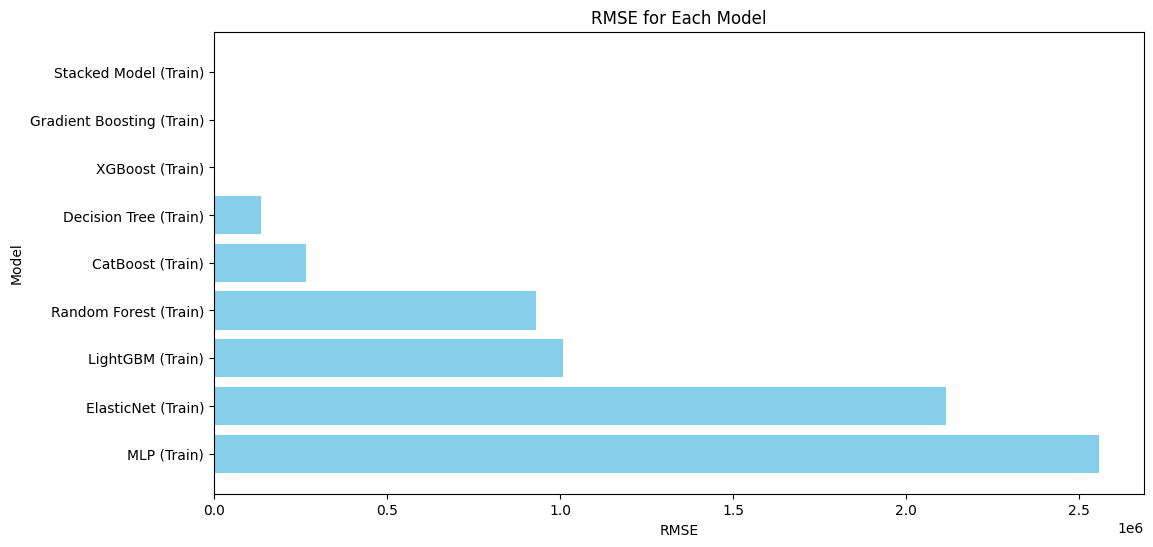

In [39]:
import matplotlib.pyplot as plt

# Plotting RMSE for All Models
plt.figure(figsize=(12, 6))
rmse_results_sorted = sorted(rmse_results, key=lambda x: x['RMSE'])
models = [result['Model'] for result in rmse_results_sorted]
rmse_values = [result['RMSE'] for result in rmse_results_sorted]
plt.barh(models, rmse_values, color='skyblue')
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.title("RMSE for Each Model")
plt.gca().invert_yaxis()
plt.show()

In [41]:
# Display RMSE Results in Tabular Format with Fixed-Point Decimal
pd.options.display.float_format = '{:.2f}'.format  # Set float display format

# Create RMSE DataFrame and Sort by RMSE
rmse_results_df = pd.DataFrame(rmse_results).sort_values(by="RMSE", ascending=True)
print("\n RMSE Results:\n")
print(rmse_results_df)

# Reset pandas display settings to avoid affecting other parts of the notebook
pd.reset_option('display.float_format')


 RMSE Results:

                       Model       RMSE
9      Stacked Model (Train)     373.67
6  Gradient Boosting (Train)     596.36
3            XGBoost (Train)    2667.37
8      Decision Tree (Train)  135711.90
5           CatBoost (Train)  266808.50
0      Random Forest (Train)  930500.44
1           LightGBM (Train) 1008057.16
2           LightGBM (Train) 1008057.16
4         ElasticNet (Train) 2115847.15
7                MLP (Train) 2558040.01


In [42]:
# prompt: save submissions of all models for kaggle

# Create a submission DataFrame for the stacked model
submission_stacked = pd.DataFrame({'Id': test['Id'], 'Prediction': stacked_test_preds})
submission_stacked.to_csv('submission_stacked.csv', index=False)

# Save submissions for individual models (example for Random Forest)
submission_rf = pd.DataFrame({'Id': test['Id'], 'Prediction': rf_test_preds})
submission_rf.to_csv('submission_rf.csv', index=False)

submission_lgb = pd.DataFrame({'Id': test['Id'], 'Prediction': lgb_test_preds})
submission_lgb.to_csv('submission_lgb.csv', index=False)

submission_xgb = pd.DataFrame({'Id': test['Id'], 'Prediction': xgb_test_preds})
submission_xgb.to_csv('submission_xgb.csv', index=False)

submission_elastic = pd.DataFrame({'Id': test['Id'], 'Prediction': elastic_test_preds})
submission_elastic.to_csv('submission_elastic.csv', index=False)

submission_cat = pd.DataFrame({'Id': test['Id'], 'Prediction': cat_test_preds})
submission_cat.to_csv('submission_cat.csv', index=False)

submission_gb = pd.DataFrame({'Id': test['Id'], 'Prediction': gb_test_preds})
submission_gb.to_csv('submission_gb.csv', index=False)

submission_mlp = pd.DataFrame({'Id': test['Id'], 'Prediction': mlp_test_preds})
submission_mlp.to_csv('submission_mlp.csv', index=False)

submission_dt = pd.DataFrame({'Id': test['Id'], 'Prediction': dt_test_preds})
submission_dt.to_csv('submission_dt.csv', index=False)

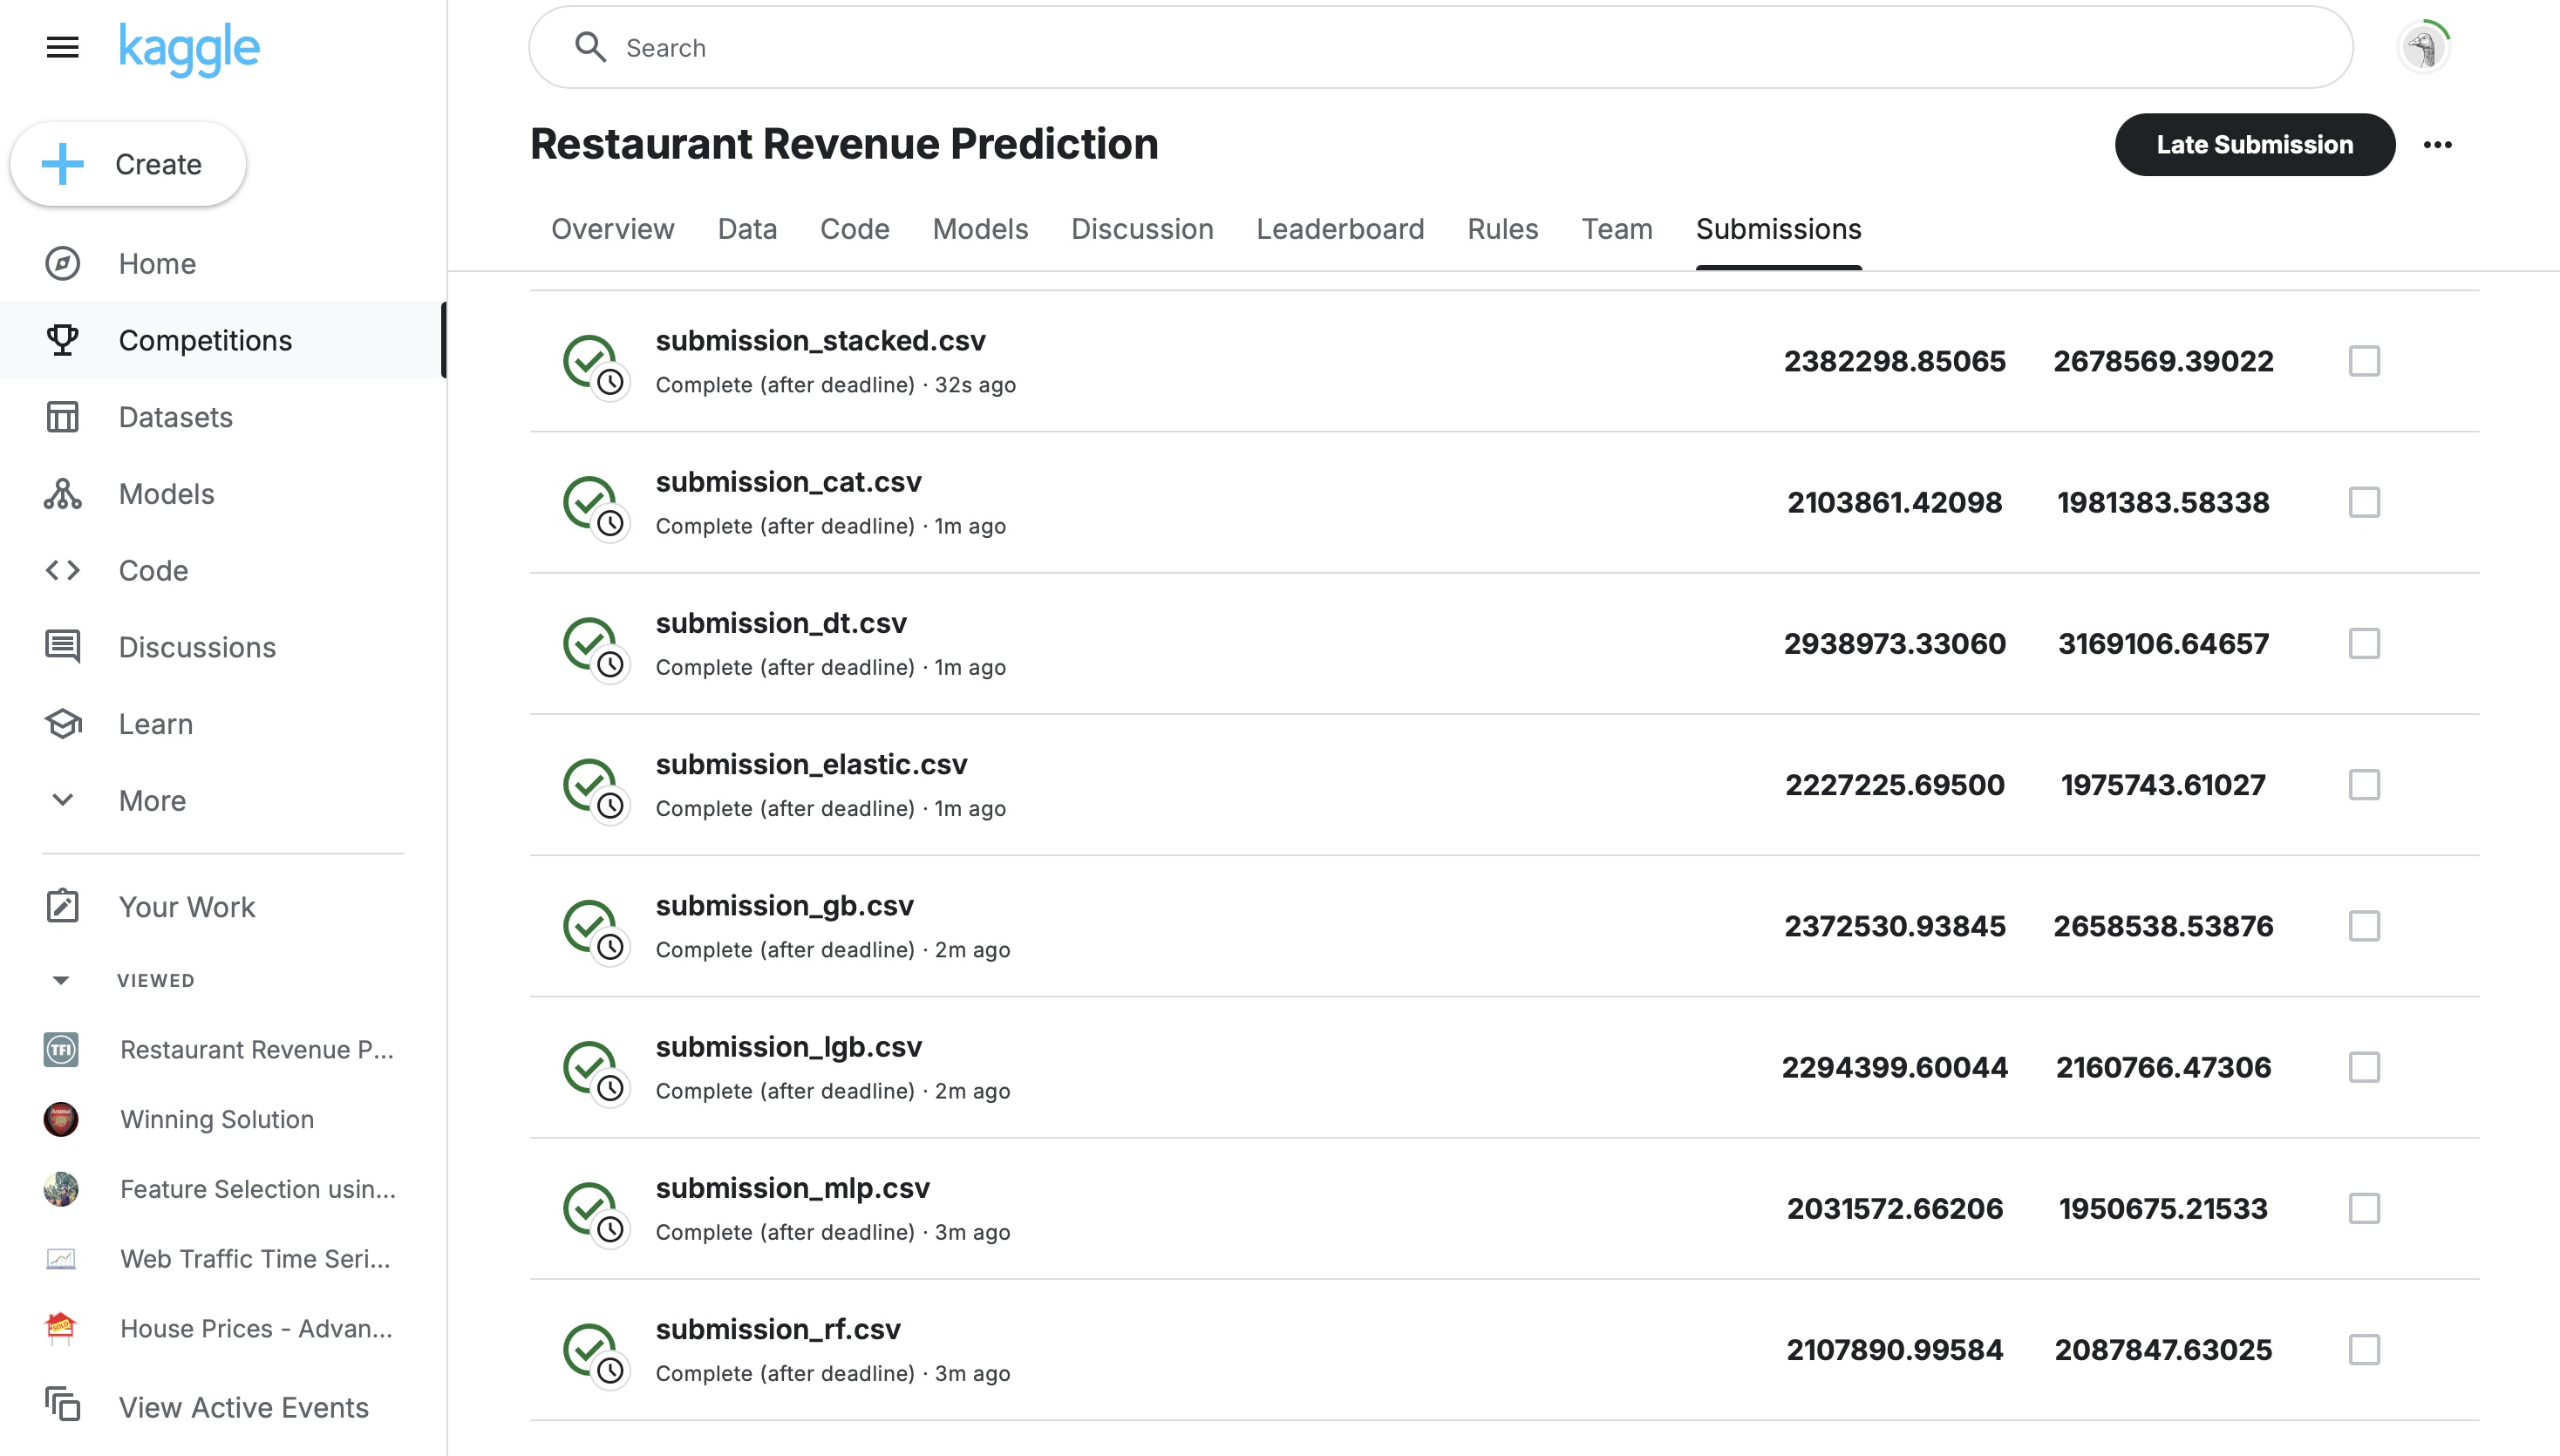

In [43]:
# prompt: add photo

from IPython.display import Image
Image('/content/initial_models.jpg') # Replace image.jpg with your image file

# Hyper-Parameter Tuning

**Why Optuna for Hyperparameter Optimization?**

Optuna is a powerful, efficient, and automated hyperparameter tuning library. It uses Bayesian optimization to find the best hyperparameters with fewer iterations compared to a grid search.

**Key Benefits:**

Dynamically adjusts the search space based on previous trials.
Faster convergence compared to GridSearchCV.
Can easily integrate with any ML library (e.g., XGBoost, LightGBM).

**Approach:**

tuning one model at a time, starting with XGBoost, then LightGBM, and finally Gradient Boosting. Optuna's dynamic search makes it ideal for faster tuning compared to GridSearchCV.

In [44]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [45]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# Define the objective function for Optuna
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    # Train XGBoost with the suggested parameters
    xgb_model = xgb.XGBRegressor(**params, random_state=42, objective='reg:squarederror')
    xgb_model.fit(X_train, y_train)

    # Predict on training data
    preds = xgb_model.predict(X_train)
    rmse = mean_squared_error(y_train, preds, squared=False)
    return rmse

# Run Optuna optimization for XGBoost
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=50)

# Best parameters and RMSE for XGBoost
print("Best XGBoost Parameters:", study_xgb.best_params)
print("Best XGBoost RMSE:", study_xgb.best_value)

[I 2024-11-26 22:37:23,083] A new study created in memory with name: no-name-dade3f9a-967e-4bec-9180-ed1dccf913ef
[I 2024-11-26 22:37:30,955] Trial 0 finished with value: 54.178004381475 and parameters: {'n_estimators': 402, 'learning_rate': 0.16294747443557653, 'max_depth': 5, 'subsample': 0.6614262729173969, 'colsample_bytree': 0.7995415118080618}. Best is trial 0 with value: 54.178004381475.
[I 2024-11-26 22:37:31,848] Trial 1 finished with value: 10820.143112754899 and parameters: {'n_estimators': 296, 'learning_rate': 0.06991955194365156, 'max_depth': 9, 'subsample': 0.662711676673525, 'colsample_bytree': 0.9335401209095555}. Best is trial 0 with value: 54.178004381475.
[I 2024-11-26 22:37:32,018] Trial 2 finished with value: 133500.19122234426 and parameters: {'n_estimators': 209, 'learning_rate': 0.05827282851804135, 'max_depth': 5, 'subsample': 0.814555600823009, 'colsample_bytree': 0.6903808362230586}. Best is trial 0 with value: 54.178004381475.
[I 2024-11-26 22:37:32,474] Tr

Best XGBoost Parameters: {'n_estimators': 236, 'learning_rate': 0.298649374035921, 'max_depth': 9, 'subsample': 0.9282356966533656, 'colsample_bytree': 0.6861393885249597}
Best XGBoost RMSE: 0.6536324666506813


In [46]:
import lightgbm as lgb
import warnings


warnings.filterwarnings("ignore")

# Define the objective function for Optuna
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }

    # Train LightGBM with the suggested parameters
    lgb_model = lgb.LGBMRegressor(**params, random_state=42)
    lgb_model.fit(X_train, y_train)

    # Predict on training data
    preds = lgb_model.predict(X_train)
    rmse = mean_squared_error(y_train, preds, squared=False)
    return rmse

# Run Optuna optimization for LightGBM
study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=50)

# Best parameters and RMSE for LightGBM
print("Best LightGBM Parameters:", study_lgb.best_params)
print("Best LightGBM RMSE:", study_lgb.best_value)

[I 2024-11-26 22:38:05,964] A new study created in memory with name: no-name-823b5f61-97fb-4cf9-b424-415184069cfb
[I 2024-11-26 22:38:06,093] Trial 0 finished with value: 1755133.9669495802 and parameters: {'n_estimators': 165, 'learning_rate': 0.08208873250041558, 'max_depth': 10, 'num_leaves': 51, 'min_child_samples': 30, 'subsample': 0.8508335148092154}. Best is trial 0 with value: 1755133.9669495802.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 43
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:06,275] Trial 1 finished with value: 1888731.6492924907 and parameters: {'n_estimators': 178, 'learning_rate': 0.013017833923307576, 'max_depth': 9, 'num_leaves': 54, 'min_child_samples': 15, 'subsample': 0.8412734032517457}. Best is trial 0 with value: 1755133.9669495802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:06,530] Trial 2 finished with value: 2012685.7933946822 and parameters: {'n_estimators': 402, 'learning_rate': 0.011040448832961678, 'max_depth': 10, 'num_leaves': 17, 'min_child_samples': 28, 'subsample': 0.7989170374568493}. Best is trial 0 with value: 1755133.9669495802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:06,727] Trial 3 finished with value: 2074168.9286901073 and parameters: {'n_estimators': 478, 'learning_rate': 0.23531696298431226, 'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 47, 'subsample': 0.7169393076482105}. Best is trial 0 with value: 1755133.9669495802.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:07,002] Trial 4 finished with value: 550679.468005874 and parameters: {'n_estimators': 446, 'learning_rate': 0.1415414614576289, 'max_depth': 10, 'num_leaves': 45, 'min_child_samples': 21, 'subsample': 0.9985844184748915}. Best is trial 4 with value: 550679.468005874.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:07,240] Trial 5 finished with value: 511764.11304370343 and parameters: {'n_estimators': 473, 'learning_rate': 0.29616306963375477, 'max_depth': 7, 'num_leaves': 39, 'min_child_samples': 26, 'subsample': 0.9994628287311709}. Best is trial 5 with value: 511764.11304370343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:07,323] Trial 6 finished with value: 2056399.4321309617 and parameters: {'n_estimators': 163, 'learning_rate': 0.16219544389550838, 'max_depth': 5, 'num_leaves': 21, 'min_child_samples': 45, 'subsample': 0.7106388179288188}. Best is trial 5 with value: 511764.11304370343.
[I 2024-11-26 22:38:07,395] Trial 7 finished with value: 1823011.500005296 and parameters: {'n_estimators': 137, 'learning_rate': 0.20703732362789534, 'max_depth': 10, 'num_leaves': 52, 'min_child_samples': 39, 'subsample': 0.6745085607660106}. Best is trial 5 with value: 511764.11304370343.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 39
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:07,619] Trial 8 finished with value: 1448610.0951860219 and parameters: {'n_estimators': 469, 'learning_rate': 0.15296723298284357, 'max_depth': 4, 'num_leaves': 62, 'min_child_samples': 35, 'subsample': 0.7857883234429127}. Best is trial 5 with value: 511764.11304370343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:07,943] Trial 9 finished with value: 1526609.014365129 and parameters: {'n_estimators': 382, 'learning_rate': 0.02238999226291217, 'max_depth': 4, 'num_leaves': 35, 'min_child_samples': 22, 'subsample': 0.7981708253020651}. Best is trial 5 with value: 511764.11304370343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:08,337] Trial 10 finished with value: 108743.21563869345 and parameters: {'n_estimators': 291, 'learning_rate': 0.29788794545768554, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 12, 'subsample': 0.9814973769269713}. Best is trial 10 with value: 108743.21563869345.
[I 2024-11-26 22:38:08,704] Trial 11 finished with value: 116615.97565174947 and parameters: {'n_estimators': 285, 'learning_rate': 0.29771314755271105, 'max_depth': 7, 'num_leaves': 35, 'min_child_samples': 12, 'subsample': 0.9952734055860558}. Best is trial 10 with value: 108743.21563869345.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:09,145] Trial 12 finished with value: 60168.059489801846 and parameters: {'n_estimators': 269, 'learning_rate': 0.2943821606285091, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 0.925835974194971}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:09,563] Trial 13 finished with value: 87223.5561780294 and parameters: {'n_estimators': 263, 'learning_rate': 0.24835447346788903, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 10, 'subsample': 0.9233924458992512}. Best is trial 12 with value: 60168.059489801846.
[I 2024-11-26 22:38:09,905] Trial 14 finished with value: 484477.5440216435 and parameters: {'n_estimators': 232, 'learning_rate': 0.242004451361868, 'max_depth': 5, 'num_leaves': 28, 'min_child_samples': 19, 'subsample': 0.9021768547321564}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:10,288] Trial 15 finished with value: 103575.3507332509 and parameters: {'n_estimators': 239, 'learning_rate': 0.24526290970498105, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 10, 'subsample': 0.9209885791695802}. Best is trial 12 with value: 60168.059489801846.
[I 2024-11-26 22:38:10,521] Trial 16 finished with value: 504832.45954697824 and parameters: {'n_estimators': 329, 'learning_rate': 0.19703828448017524, 'max_depth': 3, 'num_leaves': 15, 'min_child_samples': 17, 'subsample': 0.9286196908506217}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:10,777] Trial 17 finished with value: 748477.0459568069 and parameters: {'n_estimators': 225, 'learning_rate': 0.25708344762247715, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 24, 'subsample': 0.8722371791706616}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 43
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:11,167] Trial 18 finished with value: 182577.49744792908 and parameters: {'n_estimators': 338, 'learning_rate': 0.2736467082281214, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 15, 'subsample': 0.6146581594199532}. Best is trial 12 with value: 60168.059489801846.
[I 2024-11-26 22:38:11,371] Trial 19 finished with value: 1522976.6521898892 and parameters: {'n_estimators': 262, 'learning_rate': 0.21097420800031597, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 35, 'subsample': 0.9400091355704737}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 41
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:11,815] Trial 20 finished with value: 243563.49151617952 and parameters: {'n_estimators': 346, 'learning_rate': 0.10610766976043196, 'max_depth': 8, 'num_leaves': 20, 'min_child_samples': 10, 'subsample': 0.8803647533153421}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:12,143] Trial 21 finished with value: 95157.2428705714 and parameters: {'n_estimators': 230, 'learning_rate': 0.26960824841332914, 'max_depth': 6, 'num_leaves': 29, 'min_child_samples': 10, 'subsample': 0.9387767495093359}. Best is trial 12 with value: 60168.059489801846.
[I 2024-11-26 22:38:12,358] Trial 22 finished with value: 306344.4770218344 and parameters: {'n_estimators': 202, 'learning_rate': 0.2666809144828872, 'max_depth': 6, 'num_leaves': 29, 'min_child_samples': 15, 'subsample': 0.9530671440579742}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:12,479] Trial 23 finished with value: 776094.0647913739 and parameters: {'n_estimators': 115, 'learning_rate': 0.2258772873877103, 'max_depth': 5, 'num_leaves': 38, 'min_child_samples': 19, 'subsample': 0.9563077859574454}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:12,710] Trial 24 finished with value: 261013.71306312713 and parameters: {'n_estimators': 260, 'learning_rate': 0.18327308571153705, 'max_depth': 8, 'num_leaves': 24, 'min_child_samples': 13, 'subsample': 0.8377314831371995}. Best is trial 12 with value: 60168.059489801846.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:12,998] Trial 25 finished with value: 42500.2579316952 and parameters: {'n_estimators': 313, 'learning_rate': 0.27688595571651203, 'max_depth': 6, 'num_leaves': 40, 'min_child_samples': 10, 'subsample': 0.9017414624012197}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:13,268] Trial 26 finished with value: 247242.52422584814 and parameters: {'n_estimators': 314, 'learning_rate': 0.27425910240239904, 'max_depth': 4, 'num_leaves': 43, 'min_child_samples': 16, 'subsample': 0.8960822468963507}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:13,566] Trial 27 finished with value: 401191.4300150289 and parameters: {'n_estimators': 378, 'learning_rate': 0.22508200146313895, 'max_depth': 6, 'num_leaves': 37, 'min_child_samples': 20, 'subsample': 0.7596069614166744}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:13,800] Trial 28 finished with value: 143310.53652543208 and parameters: {'n_estimators': 274, 'learning_rate': 0.2833815892149087, 'max_depth': 5, 'num_leaves': 48, 'min_child_samples': 13, 'subsample': 0.8637289517057136}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:14,048] Trial 29 finished with value: 1554830.6104260713 and parameters: {'n_estimators': 312, 'learning_rate': 0.10748087277788532, 'max_depth': 3, 'num_leaves': 57, 'min_child_samples': 32, 'subsample': 0.902949028565687}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:14,316] Trial 30 finished with value: 1804743.6919831748 and parameters: {'n_estimators': 359, 'learning_rate': 0.18307803692983288, 'max_depth': 8, 'num_leaves': 41, 'min_child_samples': 42, 'subsample': 0.8317420165850078}. Best is trial 25 with value: 42500.2579316952.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-11-26 22:38:14,520] Trial 31 finished with value: 164266.2835833165 and parameters: {'n_estimators': 200, 'learning_rate': 0.25220584523392536, 'max_depth': 6, 'num_leaves': 32, 'min_child_samples': 11, 'subsample': 0.9686497828803803}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:14,751] Trial 32 finished with value: 75837.97837142285 and parameters: {'n_estimators': 253, 'learning_rate': 0.28018187061075256, 'max_depth': 6, 'num_leaves': 26, 'min_child_samples': 10, 'subsample': 0.921236247750211}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:14,983] Trial 33 finished with value: 308377.6850849553 and parameters: {'n_estimators': 254, 'learning_rate': 0.28215147078150377, 'max_depth': 7, 'num_leaves': 21, 'min_child_samples': 17, 'subsample': 0.9137975358744573}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:15,243] Trial 34 finished with value: 156276.2873078973 and parameters: {'n_estimators': 299, 'learning_rate': 0.2592727652101309, 'max_depth': 6, 'num_leaves': 26, 'min_child_samples': 14, 'subsample': 0.8523188346366217}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:15,589] Trial 35 finished with value: 217571.7939741625 and parameters: {'n_estimators': 423, 'learning_rate': 0.23217317954995387, 'max_depth': 7, 'num_leaves': 19, 'min_child_samples': 17, 'subsample': 0.8876303200020469}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:15,777] Trial 36 finished with value: 201490.47733581532 and parameters: {'n_estimators': 200, 'learning_rate': 0.288746032092798, 'max_depth': 5, 'num_leaves': 34, 'min_child_samples': 13, 'subsample': 0.8230250178006324}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:16,026] Trial 37 finished with value: 1461418.502019827 and parameters: {'n_estimators': 320, 'learning_rate': 0.03490400730230085, 'max_depth': 9, 'num_leaves': 46, 'min_child_samples': 23, 'subsample': 0.9716354771156599}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:16,292] Trial 38 finished with value: 78503.6668007228 and parameters: {'n_estimators': 277, 'learning_rate': 0.2545835786788818, 'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 10, 'subsample': 0.923592863728979}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:16,449] Trial 39 finished with value: 2133927.7002035226 and parameters: {'n_estimators': 174, 'learning_rate': 0.21651028969697458, 'max_depth': 7, 'num_leaves': 24, 'min_child_samples': 49, 'subsample': 0.948363032604921}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 34
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:16,684] Trial 40 finished with value: 813327.4363599985 and parameters: {'n_estimators': 288, 'learning_rate': 0.29906583861471525, 'max_depth': 9, 'num_leaves': 31, 'min_child_samples': 28, 'subsample': 0.7679640008552127}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:17,003] Trial 41 finished with value: 96684.86908736645 and parameters: {'n_estimators': 270, 'learning_rate': 0.26036570160290223, 'max_depth': 6, 'num_leaves': 26, 'min_child_samples': 11, 'subsample': 0.9171836106881328}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:17,301] Trial 42 finished with value: 97161.65590941982 and parameters: {'n_estimators': 243, 'learning_rate': 0.23918048396014077, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 10, 'subsample': 0.867643335105375}. Best is trial 25 with value: 42500.2579316952.
[I 2024-11-26 22:38:17,521] Trial 43 finished with value: 250129.57019118645 and parameters: {'n_estimators': 213, 'learning_rate': 0.27490490770509435, 'max_depth': 5, 'num_leaves': 18, 'min_child_samples': 14, 'subsample': 0.9291500196466189}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:17,841] Trial 44 finished with value: 114879.94247351898 and parameters: {'n_estimators': 304, 'learning_rate': 0.2490399389720514, 'max_depth': 6, 'num_leaves': 39, 'min_child_samples': 12, 'subsample': 0.9811466809616397}. Best is trial 25 with value: 42500.2579316952.
[I 2024-11-26 22:38:18,045] Trial 45 finished with value: 543871.6133948902 and parameters: {'n_estimators': 150, 'learning_rate': 0.2857021369679676, 'max_depth': 7, 'num_leaves': 36, 'min_child_samples': 18, 'subsample': 0.9046693681033356}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:18,265] Trial 46 finished with value: 231561.52795016198 and parameters: {'n_estimators': 279, 'learning_rate': 0.2887754710761357, 'max_depth': 4, 'num_leaves': 22, 'min_child_samples': 15, 'subsample': 0.8854461598201577}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-26 22:38:18,597] Trial 47 finished with value: 226520.55032226915 and parameters: {'n_estimators': 358, 'learning_rate': 0.1312494591637997, 'max_depth': 7, 'num_leaves': 27, 'min_child_samples': 12, 'subsample': 0.8540730801203317}. Best is trial 25 with value: 42500.2579316952.
[I 2024-11-26 22:38:18,865] Trial 48 finished with value: 173108.1567864794 and parameters: {'n_estimators': 248, 'learning_rate': 0.1915783109631688, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 10, 'subsample': 0.8080426843402466}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-11-26 22:38:19,086] Trial 49 finished with value: 1236027.4349031374 and parameters: {'n_estimators': 218, 'learning_rate': 0.06472794177302493, 'max_depth': 6, 'num_leaves': 17, 'min_child_samples': 21, 'subsample': 0.9612364431414203}. Best is trial 25 with value: 42500.2579316952.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings("ignore")

# Define the objective function for Optuna
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }

    # Train Gradient Boosting with the suggested parameters
    gb_model = GradientBoostingRegressor(**params, random_state=42)
    gb_model.fit(X_train, y_train)

    # Predict on training data
    preds = gb_model.predict(X_train)
    rmse = mean_squared_error(y_train, preds, squared=False)
    return rmse

# Run Optuna optimization for Gradient Boosting
study_gb = optuna.create_study(direction="minimize")
study_gb.optimize(objective_gb, n_trials=50)

# Best parameters and RMSE for Gradient Boosting
print("Best Gradient Boosting Parameters:", study_gb.best_params)
print("Best Gradient Boosting RMSE:", study_gb.best_value)


[I 2024-11-26 22:38:36,217] A new study created in memory with name: no-name-31097b80-1ee2-42e8-a1ab-613407dcf7b8
[I 2024-11-26 22:38:37,250] Trial 0 finished with value: 1.3951259295143811e-08 and parameters: {'n_estimators': 484, 'learning_rate': 0.2780351022940732, 'max_depth': 5, 'subsample': 0.7815541648163298}. Best is trial 0 with value: 1.3951259295143811e-08.
[I 2024-11-26 22:38:38,111] Trial 1 finished with value: 0.7207002463392777 and parameters: {'n_estimators': 271, 'learning_rate': 0.12312618765045985, 'max_depth': 8, 'subsample': 0.6659739758130276}. Best is trial 0 with value: 1.3951259295143811e-08.
[I 2024-11-26 22:38:38,807] Trial 2 finished with value: 192.95020756963825 and parameters: {'n_estimators': 270, 'learning_rate': 0.0914594265168072, 'max_depth': 6, 'subsample': 0.7588102297095849}. Best is trial 0 with value: 1.3951259295143811e-08.
[I 2024-11-26 22:38:40,602] Trial 3 finished with value: 1.7030438537802905e-05 and parameters: {'n_estimators': 464, 'lea

Best Gradient Boosting Parameters: {'n_estimators': 343, 'learning_rate': 0.26803200985394404, 'max_depth': 7, 'subsample': 0.8370852953552962}
Best Gradient Boosting RMSE: 1.3335607884913395e-08


In [48]:
# Compile the best parameters and RMSE results
optuna_results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'Gradient Boosting'],
    'Best Parameters': [study_xgb.best_params, study_lgb.best_params, study_gb.best_params],
    'Best RMSE': [study_xgb.best_value, study_lgb.best_value, study_gb.best_value]
})

# Format RMSE values to be more human-readable
optuna_results['Best RMSE'] = optuna_results['Best RMSE'].map(lambda x: f"{x:.8f}")

# Display the results
print("\nHyperparameter Tuning Results:\n")
print(optuna_results)


Hyperparameter Tuning Results:

               Model                                    Best Parameters  \
0            XGBoost  {'n_estimators': 236, 'learning_rate': 0.29864...   
1           LightGBM  {'n_estimators': 313, 'learning_rate': 0.27688...   
2  Gradient Boosting  {'n_estimators': 343, 'learning_rate': 0.26803...   

        Best RMSE  
0      0.65363247  
1  42500.25793170  
2      0.00000001  


Next Steps:
1. Combine predictions from XGBoost, LightGBM, and Gradient Boosting in a stacked model to potentially improve the RMSE further
2.Refine stacked Model
3. Perform feature selection

In [49]:
# Validate Tuned Model on Test Set

# Retrain XGBoost
xgb_best_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
xgb_best_model.fit(X_train, y_train)

# Retrain LightGBM
lgb_best_model = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42)
lgb_best_model.fit(X_train, y_train)

# Retrain Gradient Boosting
gb_best_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
gb_best_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

GradientBoostingRegressor(learning_rate=0.26803200985394404, max_depth=7,
                          n_estimators=343, random_state=42,
                          subsample=0.8370852953552962)

In [50]:
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

# XGBoost cross-validation
xgb_best_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
xgb_cv_rmse = -cross_val_score(xgb_best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"XGBoost Cross-Validation RMSE: {xgb_cv_rmse:.4f}")

# LightGBM cross-validation
lgb_best_model = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42)
lgb_cv_rmse = -cross_val_score(lgb_best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"LightGBM Cross-Validation RMSE: {lgb_cv_rmse:.4f}")

# Gradient Boosting cross-validation
gb_best_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
gb_cv_rmse = -cross_val_score(gb_best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f"Gradient Boosting Cross-Validation RMSE: {gb_cv_rmse:.4f}")

XGBoost Cross-Validation RMSE: 2822363.5952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 44
[LightGBM] [Info] Start training from score 4343891.798165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [51]:
print(f"XGBoost Cross-Validation RMSE: {xgb_cv_rmse:.4f}")
print(f"LightGBM Cross-Validation RMSE: {lgb_cv_rmse:.4f}")
print(f"Gradient Boosting Cross-Validation RMSE: {gb_cv_rmse:.4f}")

XGBoost Cross-Validation RMSE: 2822363.5952
LightGBM Cross-Validation RMSE: 2701208.0354
Gradient Boosting Cross-Validation RMSE: 3031454.6917


In [52]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

warnings.filterwarnings("ignore")

# Initialize arrays for out-of-fold predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_oof_preds = np.zeros(len(X_train))
lgb_oof_preds = np.zeros(len(X_train))
gb_oof_preds = np.zeros(len(X_train))

# Train models and generate out-of-fold predictions
for train_idx, valid_idx in kf.split(X_train):
    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # XGBoost
    xgb_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
    xgb_model.fit(X_tr, y_tr)
    xgb_oof_preds[valid_idx] = xgb_model.predict(X_val)

    # LightGBM
    lgb_model = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42)
    lgb_model.fit(X_tr, y_tr)
    lgb_oof_preds[valid_idx] = lgb_model.predict(X_val)

    # Gradient Boosting
    gb_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
    gb_model.fit(X_tr, y_tr)
    gb_oof_preds[valid_idx] = gb_model.predict(X_val)

# Calculate RMSE for the base model predictions
xgb_rmse = mean_squared_error(y_train, xgb_oof_preds, squared=False)
lgb_rmse = mean_squared_error(y_train, lgb_oof_preds, squared=False)
gb_rmse = mean_squared_error(y_train, gb_oof_preds, squared=False)

print(f"XGBoost OOF RMSE: {xgb_rmse:.4f}")
print(f"LightGBM OOF RMSE: {lgb_rmse:.4f}")
print(f"Gradient Boosting OOF RMSE: {gb_rmse:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 44
[LightGBM] [Info] Start training from score 4375994.238532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [54]:
# Create the meta-dataset
meta_X_train = pd.DataFrame({
    'XGBoost': xgb_oof_preds,
    'LightGBM': lgb_oof_preds,
    'GradientBoosting': gb_oof_preds
})

# Train the stacked model (Ridge Regression)
meta_model = Ridge(alpha=1.0)  # Regularized meta-model
meta_model.fit(meta_X_train, y_train)

# Predict on the meta-dataset
stacked_train_preds = meta_model.predict(meta_X_train)

# Calculate RMSE for the stacked model
stacked_rmse = mean_squared_error(y_train, stacked_train_preds, squared=False)
print(f"Stacked Model RMSE: {stacked_rmse:.4f}")

Stacked Model RMSE: 2403815.4072


In [55]:
print(f"XGBoost OOF RMSE: {xgb_rmse:.4f}")
print(f"LightGBM OOF RMSE: {lgb_rmse:.4f}")
print(f"Gradient Boosting OOF RMSE: {gb_rmse:.4f}")
print(f"Stacked Model RMSE: {stacked_rmse:.4f}")

XGBoost OOF RMSE: 2548331.5149
LightGBM OOF RMSE: 2762470.2336
Gradient Boosting OOF RMSE: 3006455.1659
Stacked Model RMSE: 2403815.4072


In [58]:
# Generate base model predictions for the test data
# Fit the xgb_best_model before predicting
xgb_best_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
xgb_best_model.fit(X_train, y_train)  # This line is crucial
xgb_test_preds = xgb_best_model.predict(X_test)

# Fit the lgb_best_model before predicting
lgb_best_model = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42)
lgb_best_model.fit(X_train, y_train)
lgb_test_preds = lgb_best_model.predict(X_test)

# Fit the gb_best_model before predicting
gb_best_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
gb_best_model.fit(X_train, y_train)
gb_test_preds = gb_best_model.predict(X_test)

# Create the meta-dataset for the test data
meta_X_test = pd.DataFrame({
    'XGBoost': xgb_test_preds,
    'LightGBM': lgb_test_preds,
    'GradientBoosting': gb_test_preds
})

# Predict using the stacked model
stacked_test_preds = meta_model.predict(meta_X_test)

# Save predictions for submission
submission_stacked = pd.DataFrame({'Id': test['Id'], 'Prediction': stacked_test_preds})
submission_stacked.to_csv('tuned_stacked_model_submission.csv', index=False)
print("Stacked model predictions saved as 'tuned_stacked_model_submission.csv'.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 44
[LightGBM] [Info] Start training from score 4453532.620438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

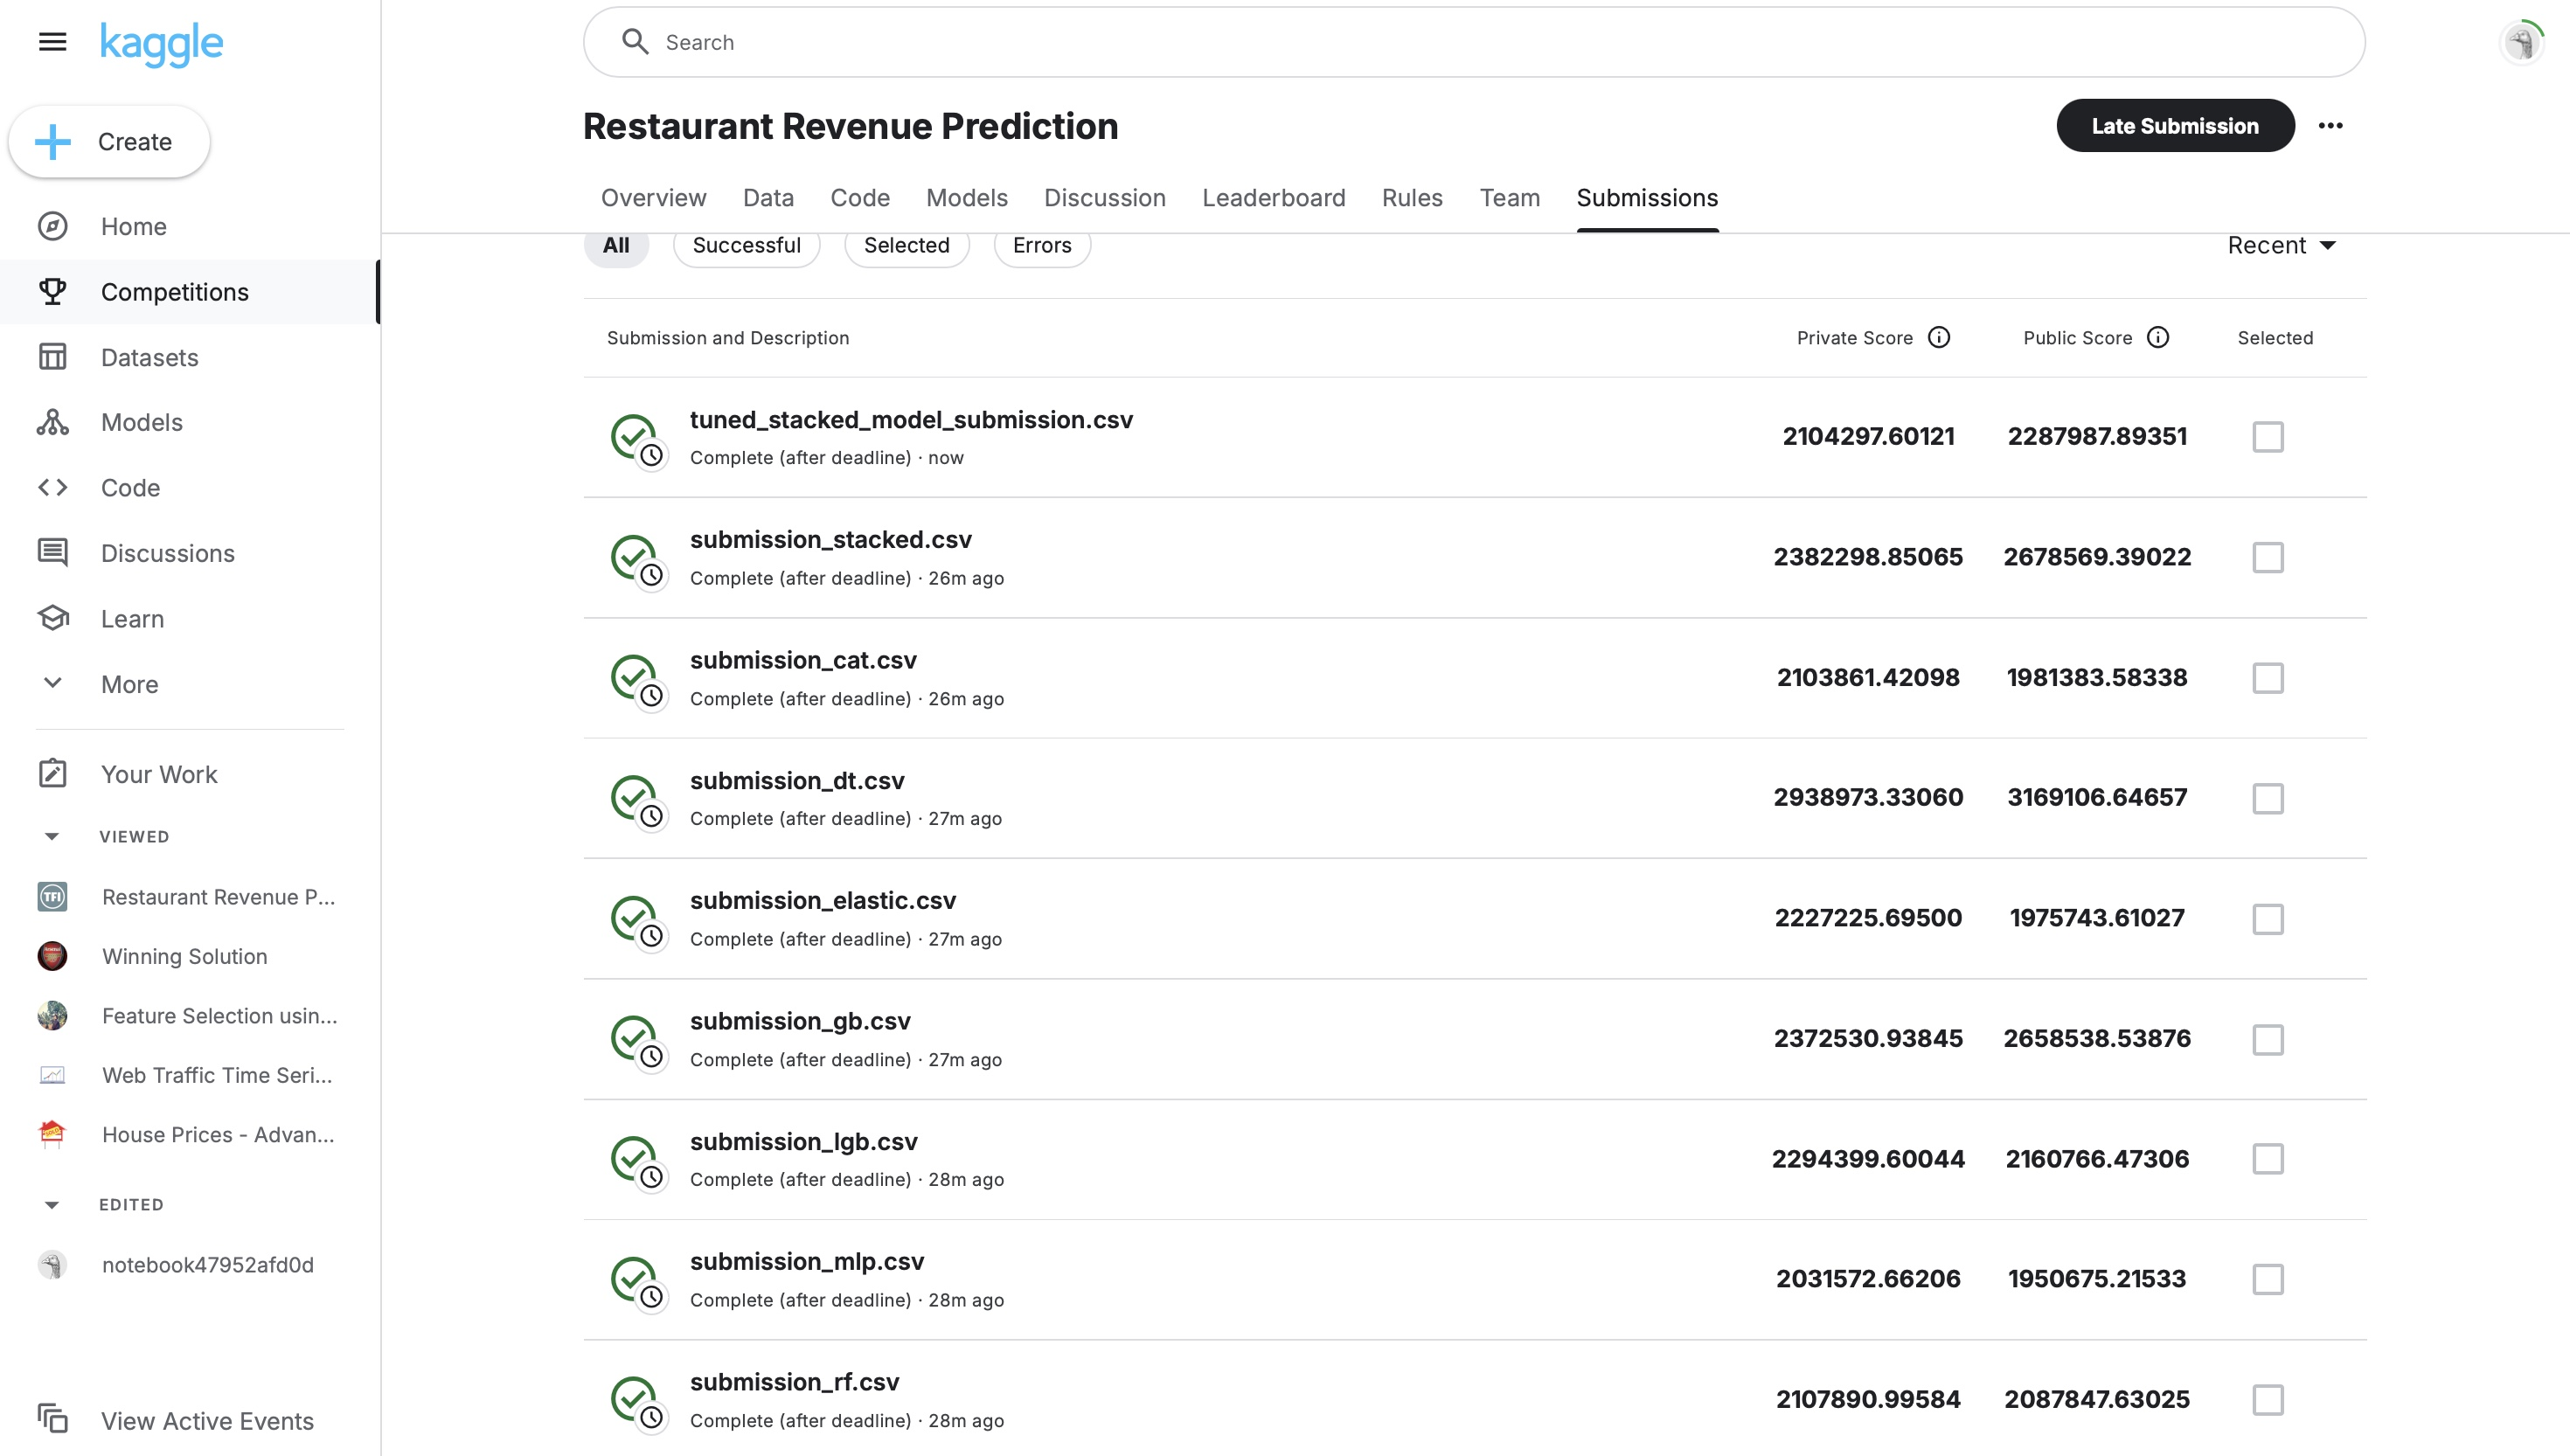

In [59]:


Image('/content/Tuned_Stacked.jpg')


# Feature Selection

perform feature selection to potentially improve the model’s performance. While tree-based models like XGBoost, LightGBM, and Gradient Boosting perform implicit feature selection, an explicit feature selection step can help reduce noise, improve interpretability, and potentially enhance generalization.

**Why Feature selection is done toward the end?**

- Avoid Premature Elimination: Early feature removal can discard important information. By training models on all features first, we establish a performance baseline.

- Tree-Based Models Handle Irrelevant Features: Models like XGBoost and Gradient Boosting inherently manage irrelevant features through feature importance metrics.

- More Robust Selection: After tuning, the models provide better insights into which features matter most.

- Simplifies and Improves Interpretability: Feature selection at the end refines models, reduces overfitting, and focuses on the most impactful features.

**Why It’s primarily done on XGBoost and Gradient Boosting:**

These models provide feature importance metrics.
They capture complex, non-linear relationships, and feature selection can enhance generalization.
Other models (e.g., ElasticNet, MLP) are more sensitive to preprocessing, scaling, or regularization, so they rely less on explicit feature selection.

**When should Feature selection should be done early?**

- High Dimensionality: Large datasets with thousands of features (e.g., text or genomic data) need dimensionality reduction to save time and resources.
- Strong Correlation: Redundant or highly correlated features can be removed early to simplify the model.
- Linear Models: Models like ElasticNet or Ridge are sensitive to irrelevant features and benefit from early selection.
- Noisy Features: Removing constant or irrelevant features early improves data quality.
- Domain Knowledge: If experts identify irrelevant features, they can be eliminated before training.

**In short, early selection is necessary when feature volume, redundancy, or noise risks overwhelming the modeling process**

In [60]:
from sklearn.feature_selection import SelectFromModel

# Train XGBoost model to compute feature importance
xgb_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Use SelectFromModel to select features
sfm = SelectFromModel(estimator=xgb_model, threshold='median', prefit=True)
X_train_sfm = sfm.transform(X_train)
X_test_sfm = sfm.transform(X_test)

print(f"SelectFromModel: Selected {X_train_sfm.shape[1]} features out of {X_train.shape[1]}")

# Retrain XGBoost with selected features
xgb_model_sfm = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
xgb_model_sfm.fit(X_train_sfm, y_train)
xgb_rmse_sfm = mean_squared_error(y_train, xgb_model_sfm.predict(X_train_sfm), squared=False)
print(f"XGBoost RMSE (SelectFromModel): {xgb_rmse_sfm:.4f}")

SelectFromModel: Selected 23 features out of 45
XGBoost RMSE (SelectFromModel): 0.6742


In [61]:
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize Gradient Boosting
gb_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)

# Sequential forward feature selection
sfs = SequentialFeatureSelector(gb_model, n_features_to_select=10, direction='forward', scoring='neg_root_mean_squared_error', cv=3)
sfs.fit(X_train, y_train)

# Get selected features
selected_features_sfs = X_train.columns[sfs.get_support()]
X_train_sfs = X_train[selected_features_sfs]
X_test_sfs = X_test[selected_features_sfs]

print(f"SequentialFeatureSelector: Selected features: {list(selected_features_sfs)}")

# Retrain Gradient Boosting with selected features
gb_model_sfs = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
gb_model_sfs.fit(X_train_sfs, y_train)
gb_rmse_sfs = mean_squared_error(y_train, gb_model_sfs.predict(X_train_sfs), squared=False)
print(f"Gradient Boosting RMSE (SequentialFeatureSelector): {gb_rmse_sfs:.4f}")


SequentialFeatureSelector: Selected features: ['P15', 'P16', 'P17', 'P26', 'P30', 'P36', 'City_Group', 'Type_DT', 'Type_FC', 'Type_IL']
Gradient Boosting RMSE (SequentialFeatureSelector): 2121835.6984


In [62]:
pip install sklearn-genetic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00


In [64]:
from genetic_selection import GeneticSelectionCV
from sklearn.linear_model import Ridge

# Genetic algorithm for feature selection
genetic_selector = GeneticSelectionCV(
    estimator=Ridge(),
    cv=3,
    scoring='neg_root_mean_squared_error',
    max_features=10,
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=10,
    verbose=1,
)
genetic_selector.fit(X_train, y_train)

# Get selected features
selected_features_genetic = X_train.columns[genetic_selector.support_]
X_train_genetic = X_train[selected_features_genetic]
X_test_genetic = X_test[selected_features_genetic]

print(f"GeneticSelectionCV: Selected features: {list(selected_features_genetic)}")

# Retrain Ridge Regression with selected features
ridge_model_genetic = Ridge()
ridge_model_genetic.fit(X_train_genetic, y_train)
ridge_rmse_genetic = mean_squared_error(y_train, ridge_model_genetic.predict(X_train_genetic), squared=False)
print(f"Ridge RMSE (GeneticSelectionCV): {ridge_rmse_genetic:.4f}")

Selecting features with genetic algorithm.
gen	nevals	avg                                              	std                                        	min                                              	max                                              
0  	50    	[-2557985.552722        5.52       187001.938445]	[ 73534.250137      2.858251  60930.456636]	[-2725032.244572        1.          81554.531155]	[-2420046.193632       10.         362469.452469]
1  	34    	[-2447496.864647        5.72       161684.958406]	[ 352764.887779       2.849842   55274.067436]	[-2627067.7304        1.        10000.    ]      	[-10000.           11.       304595.349895]      
2  	33    	[-2222418.933349        6.9        148611.130087]	[ 738458.243544       2.780288   69953.449042]	[-2551069.785595        1.          10000.      ]	[-10000.           12.       304595.349895]      
3  	26    	[-2004514.543225        7.32       128434.342732]	[ 935333.594803       2.774455   77980.986839]	[-2553213.580877       


Feature Selection RMSE Comparison:

                      Method              Model              RMSE
0            SelectFromModel            XGBoost        0.67424600
1  SequentialFeatureSelector  Gradient Boosting  2121835.69840228
2         GeneticSelectionCV   Ridge Regression  2403293.95525968


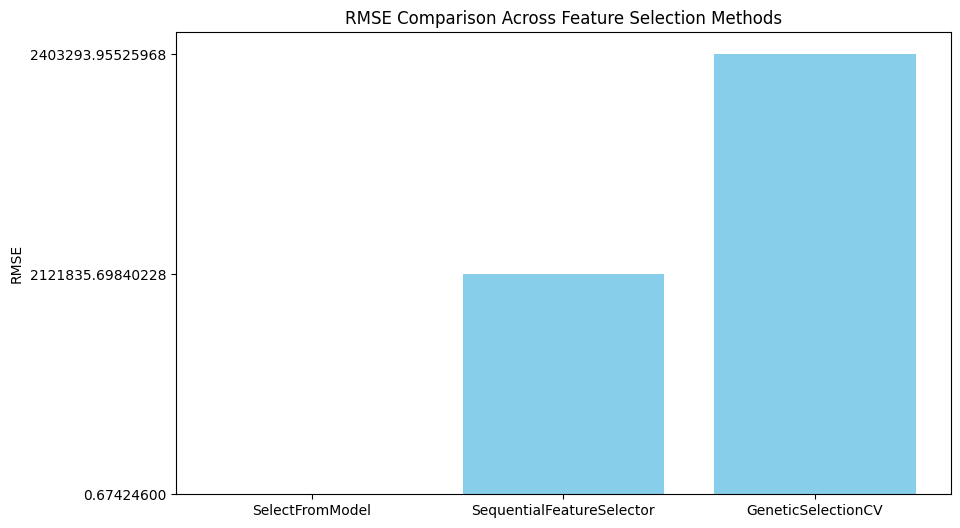

In [66]:
# Collect RMSE results
rmse_comparison = pd.DataFrame({
    'Method': ['SelectFromModel', 'SequentialFeatureSelector', 'GeneticSelectionCV'],
    'Model': ['XGBoost', 'Gradient Boosting', 'Ridge Regression'],
    'RMSE': [xgb_rmse_sfm, gb_rmse_sfs, ridge_rmse_genetic]
})
# Format RMSE values to be more human-readable
rmse_comparison['RMSE'] = rmse_comparison['RMSE'].map(lambda x: f"{x:.8f}")

print("\nFeature Selection RMSE Comparison:\n")
print(rmse_comparison)

# Visualize RMSE Comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(rmse_comparison['Method'], rmse_comparison['RMSE'], color='skyblue')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Feature Selection Methods')
plt.show()

In [67]:
# Retrain XGBoost with selected features
xgb_model_final = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
xgb_model_final.fit(X_train_sfm, y_train)

# Predict on the test set
xgb_test_preds_final = xgb_model_final.predict(X_test_sfm)

# Calculate RMSE on the training set for evaluation
xgb_rmse_final = mean_squared_error(y_train, xgb_model_final.predict(X_train_sfm), squared=False)
print(f"Final XGBoost RMSE (Selected Features): {xgb_rmse_final:.4f}")

# Save predictions for submission
submission_xgb_final = pd.DataFrame({'Id': test['Id'], 'Prediction': xgb_test_preds_final})
submission_xgb_final.to_csv('xgboost_selected_features_submission.csv', index=False)
print("Final XGBoost predictions saved as 'xgboost_selected_features_submission.csv'.")

Final XGBoost RMSE (Selected Features): 0.6742
Final XGBoost predictions saved as 'xgboost_selected_features_submission.csv'.


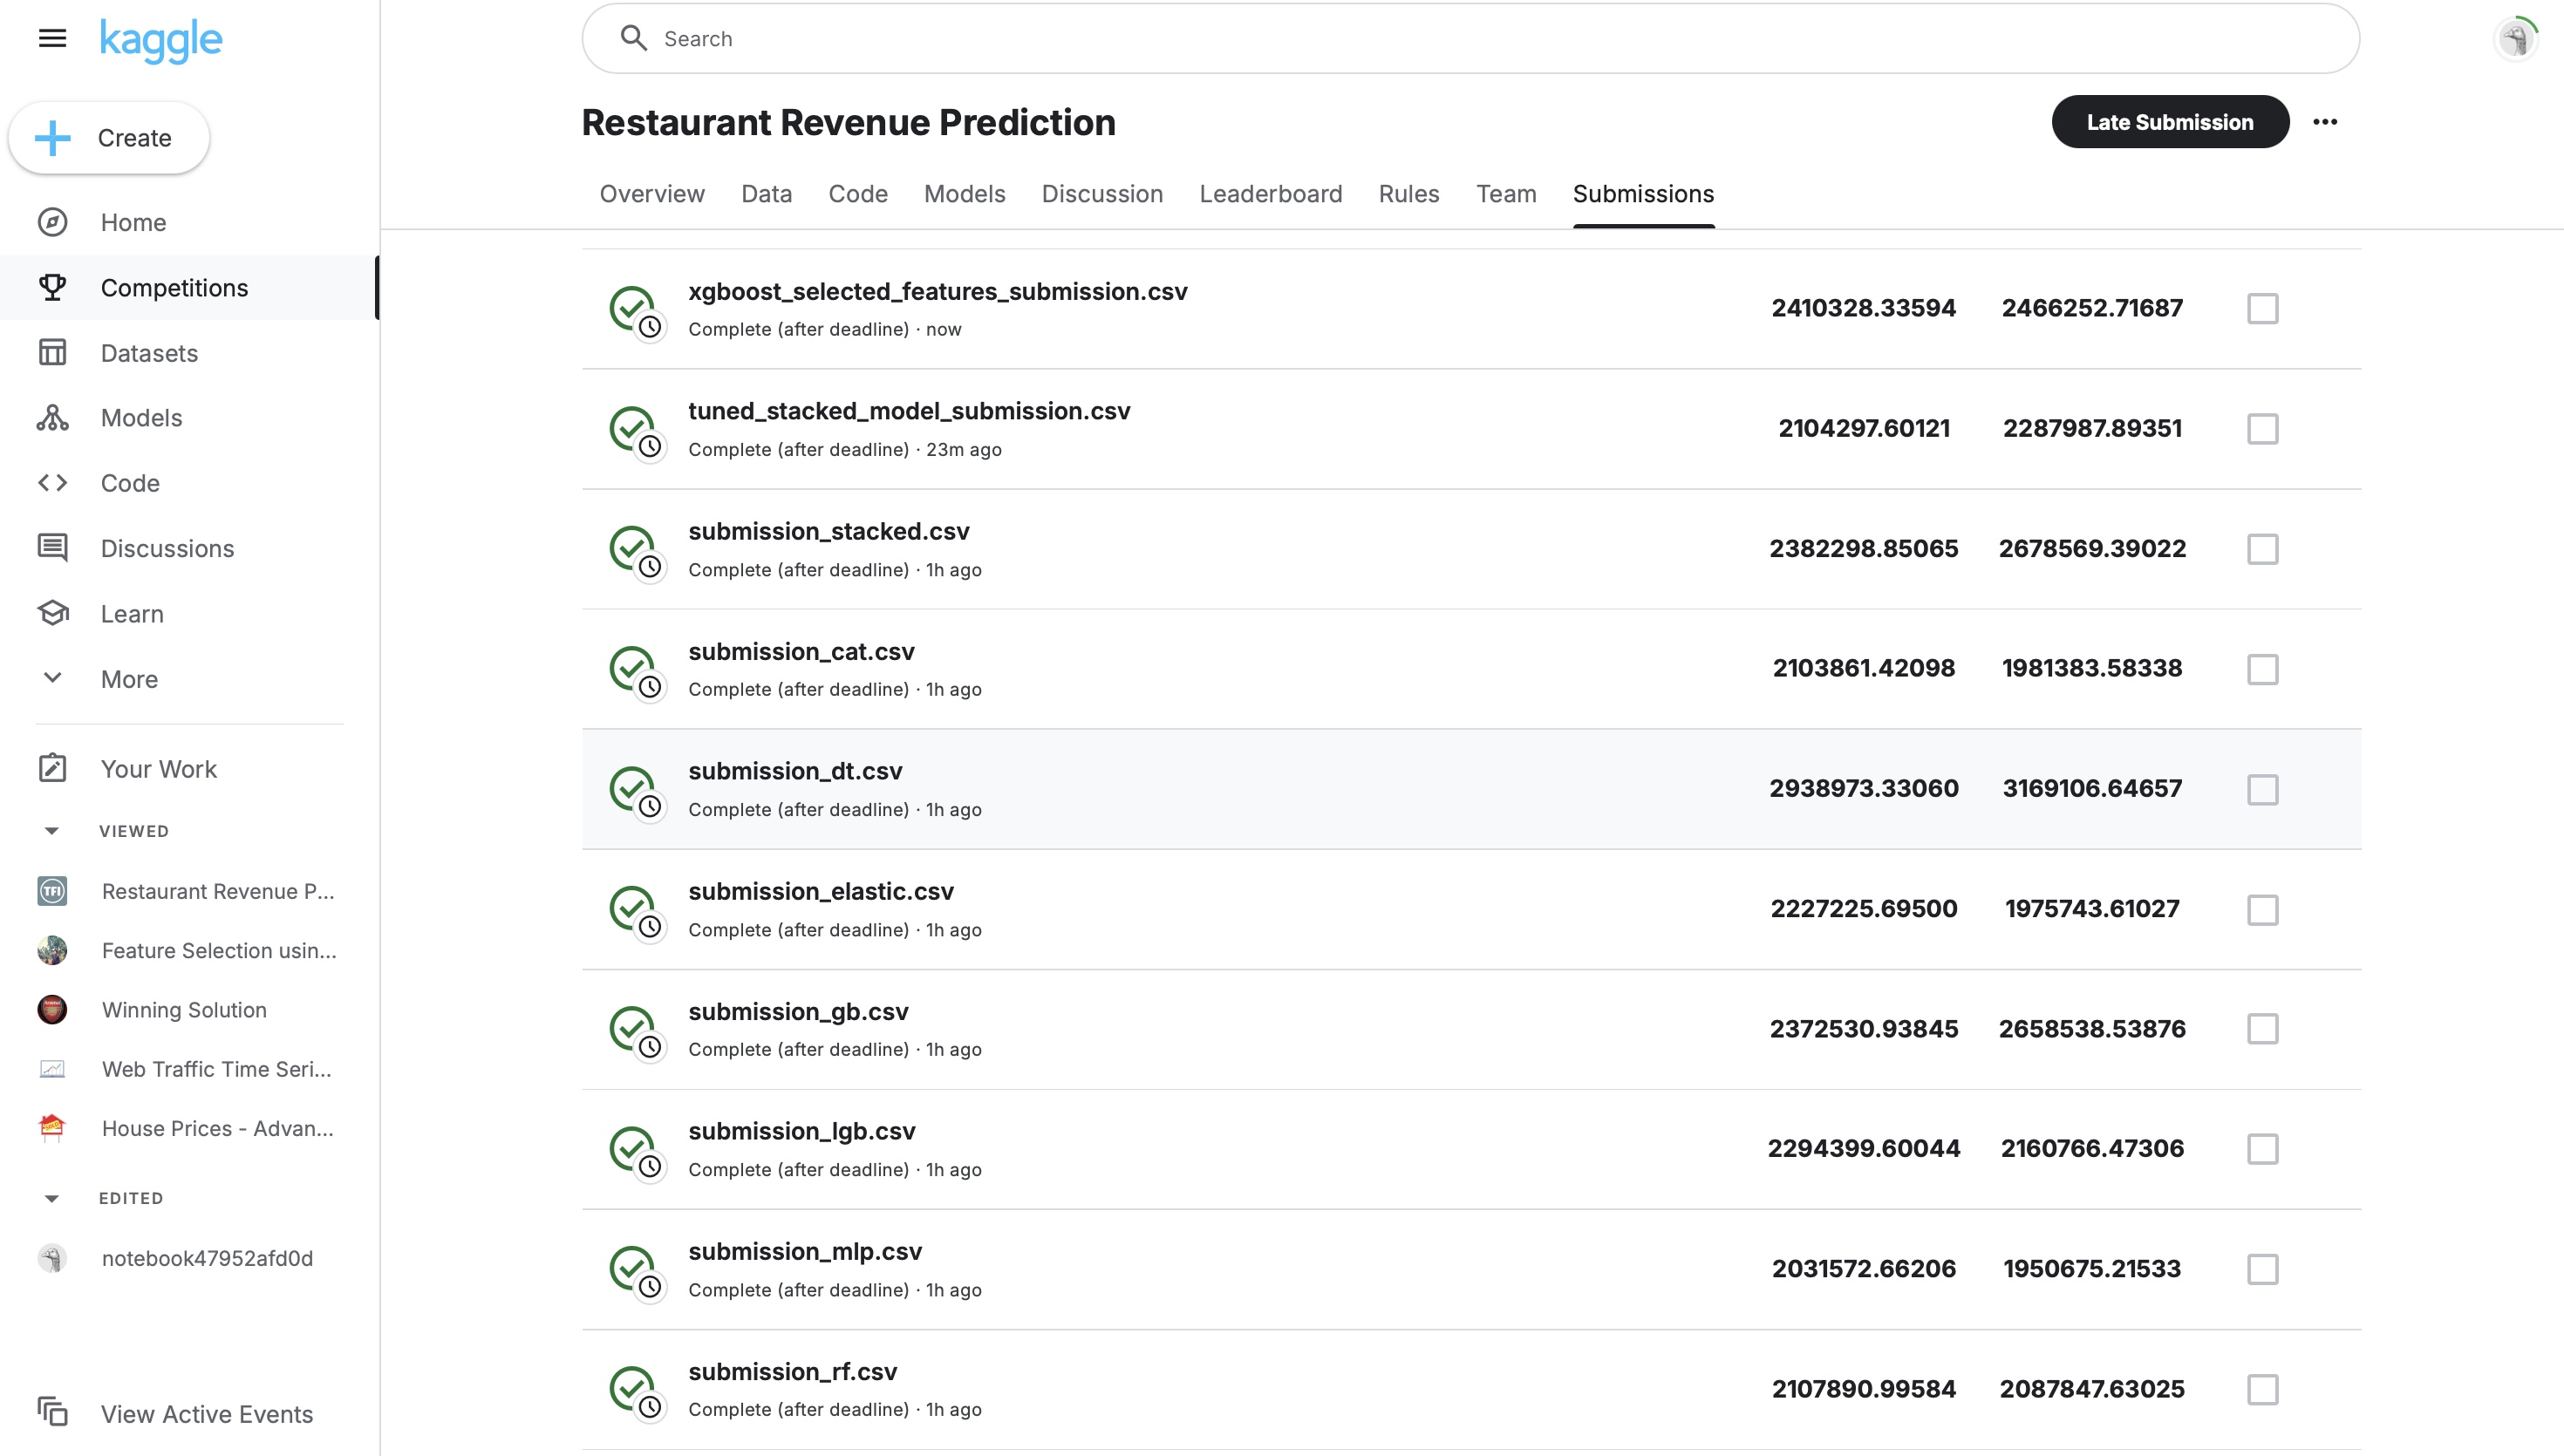

In [68]:
Image('/content/XGBoost_feature_selected.jpg')

In [69]:

# Initialize arrays for out-of-fold predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_oof_preds = np.zeros(len(X_train_sfm))
lgb_oof_preds = np.zeros(len(X_train_sfm))
gb_oof_preds = np.zeros(len(X_train_sfm))

# Train models and generate out-of-fold predictions
for train_idx, valid_idx in kf.split(X_train_sfm):
    # Split data
    X_tr, X_val = X_train_sfm[train_idx], X_train_sfm[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # XGBoost
    xgb_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, objective='reg:squarederror')
    xgb_model.fit(X_tr, y_tr)
    xgb_oof_preds[valid_idx] = xgb_model.predict(X_val)

    # LightGBM
    lgb_model = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42)
    lgb_model.fit(X_tr, y_tr)
    lgb_oof_preds[valid_idx] = lgb_model.predict(X_val)

    # Gradient Boosting
    gb_model = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
    gb_model.fit(X_tr, y_tr)
    gb_oof_preds[valid_idx] = gb_model.predict(X_val)

# Create the meta-dataset
meta_X_train = pd.DataFrame({
    'XGBoost': xgb_oof_preds,
    'LightGBM': lgb_oof_preds,
    'GradientBoosting': gb_oof_preds
})

# Train the stacked model (Ridge Regression)
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_X_train, y_train)

# Generate test predictions from base models
xgb_test_preds = xgb_model_final.predict(X_test_sfm)
lgb_test_preds = lgb_model.predict(X_test_sfm)
gb_test_preds = gb_model.predict(X_test_sfm)

# Create meta-dataset for test predictions
meta_X_test = pd.DataFrame({
    'XGBoost': xgb_test_preds,
    'LightGBM': lgb_test_preds,
    'GradientBoosting': gb_test_preds
})

# Predict using the stacked model
stacked_test_preds = meta_model.predict(meta_X_test)
stacked_rmse_final = mean_squared_error(y_train, meta_model.predict(meta_X_train), squared=False)
print(f"Final Stacked Model RMSE: {stacked_rmse_final:.4f}")

# Save stacked model predictions for submission
submission_stacked = pd.DataFrame({'Id': test['Id'], 'Prediction': stacked_test_preds})
submission_stacked.to_csv('stacked_model_selected_features_submission.csv', index=False)
print("Final Stacked Model predictions saved as 'stacked_model_selected_features_submission.csv'.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 23
[LightGBM] [Info] Start training from score 4375994.238532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

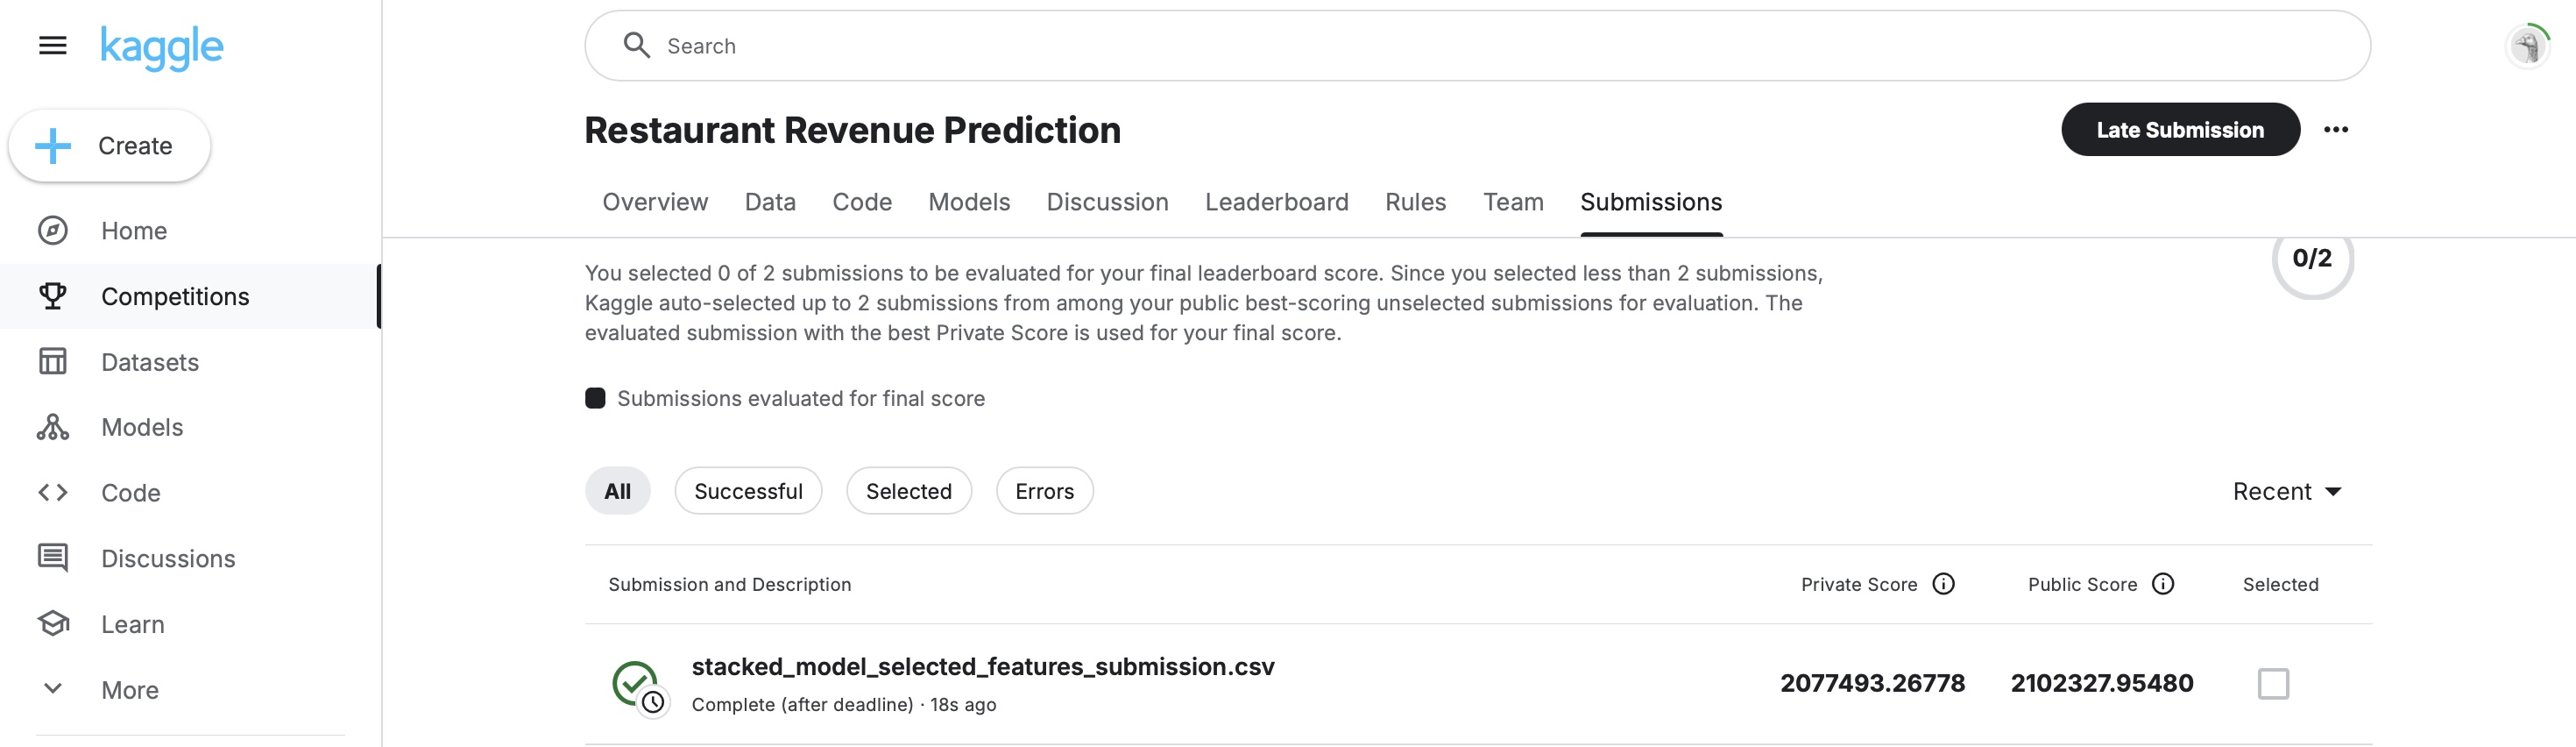

In [70]:
Image('/content/Stacked_selected_feature.jpg')

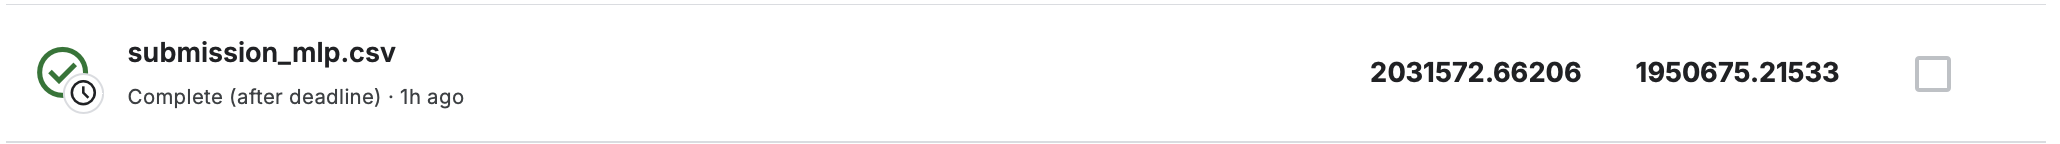

In [71]:
Image('/content/best_individual.png')